# Movie Recommendation System for Netflix

Phase: 4 Group: 13

Group Members:

- Sylvia Manono
- Amos Kipngetich
- Angela Maina
- Charles Ndegwa
- Sandra Koech
- Gloria Tisnanga
- Alex Miningwa

Student Pace: Part time

Scheduled Project Review Date/Time: October 14, 2024

Instructor Name: Samuel G. Mwangi

# Summary

## Business and Data Understanding

The stakeholder for this project is Netflix, a global streaming platform with a vast and diverse movie catalog. Netflix's mission is to provide personalized content to its users, ensuring they stay engaged and satisfied with their viewing experience.



With thousands of movies available on Netflix, users often face difficulty in discovering new content that aligns with their preferences, leading to decision fatigue and potentially lower engagement. Netflix wants to enhance its recommendation engine by suggesting movies similar to those users have already enjoyed and the characteristics of the films.

The dataset consists of four CSV files merged into a comprehensive DataFrame, capturing user interactions with movies. The key attributes include userId, movieId, rating, title, genres, imdbId, and tmdbId. This data is well-suited for a recommendation system as it provides rich information on user preferences and movie characteristics, enabling tailored recommendations based on collaborative and content-based filtering methods.

## Objective

The objective of this project is to develop a movie recommendation system for Netflix, leveraging user ratings and movie attributes.  The system suggests relevant films to users, keeping them engaged on the platform and increasing viewing time. This system will help Netflix continue to offer a personalized and enjoyable user experience.

## Data Preparation

The data preparation process involved cleaning the dataset to handle missing values. We dropped columns that were not essential, specifically the tag and timestamp_y, which contained numerous NaN entries. We filled NaN values in the tmdbId column with zero, ensuring that the dataset is complete and ready for analysis. 

The resulting DataFrame was transformed into a user-item matrix, allowing us to apply collaborative filtering techniques. The Pandas and NumPy libraries were utilized for data manipulation, and Scikit-learn was employed for similarity calculations.

## Modeling

For the modeling phase, we implemented two distinct approaches: collaborative filtering and content-based filtering. The collaborative filtering model used cosine similarity to identify users with similar rating patterns, generating recommendations based on their preferences. 

The content-based filtering model analyzed movie genres using the TF-IDF vectorizer to determine similarities between movies, allowing for genre-based recommendations. The combined use of these techniques aimed to enhance the recommendation accuracy and user experience.

## Evaluation
The collaborative filtering model's performance was evaluated by examining the top movie recommendations derived from similar users. The content-based filtering model was tested by providing users with movie suggestions based on genre similarities. 

While specific numerical evaluation metrics like RMSE were not computed for collaborative filtering, the effectiveness of recommendations was assessed qualitatively through the relevancy of suggested titles.

### 1. Importing Libraries

Import necessary libraries for data manipulation, modeling, and evaluation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from surprise import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

### 2. Loading the Datasets

In [2]:
# Load the CSV files
movies_df = pd.read_csv('ml-latest-small/movies.csv')
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
tags_df = pd.read_csv('ml-latest-small/tags.csv')
links_df = pd.read_csv('ml-latest-small/links.csv')



### 3. Exploratory Data Analysis (EDA)

Conduct initial exploration to understand the data structure and identify any issues.

In [3]:
# Display the first few rows of each file to understand their structure
print(movies_df.head())
print(ratings_df.head())
print(tags_df.head())
print(links_df.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferre

### 4. Data Merging

In [4]:
# Merge ratings with movies to associate ratings with movie titles
ratings_movies_df = pd.merge(ratings_df, movies_df, on='movieId', how='inner')

# Merge with tags to include movie tags for content-based filtering
ratings_movies_tags_df = pd.merge(ratings_movies_df, tags_df, on=['userId', 'movieId'], how='left')

# Merge with links to associate external database IDs (if needed)
final_df = pd.merge(ratings_movies_tags_df, links_df, on='movieId', how='left')

# Inspect the final dataset
print(final_df.head())


   userId  movieId  rating  timestamp_x             title  \
0       1        1     4.0    964982703  Toy Story (1995)   
1       5        1     4.0    847434962  Toy Story (1995)   
2       7        1     4.5   1106635946  Toy Story (1995)   
3      15        1     2.5   1510577970  Toy Story (1995)   
4      17        1     4.5   1305696483  Toy Story (1995)   

                                        genres  tag  timestamp_y  imdbId  \
0  Adventure|Animation|Children|Comedy|Fantasy  NaN          NaN  114709   
1  Adventure|Animation|Children|Comedy|Fantasy  NaN          NaN  114709   
2  Adventure|Animation|Children|Comedy|Fantasy  NaN          NaN  114709   
3  Adventure|Animation|Children|Comedy|Fantasy  NaN          NaN  114709   
4  Adventure|Animation|Children|Comedy|Fantasy  NaN          NaN  114709   

   tmdbId  
0   862.0  
1   862.0  
2   862.0  
3   862.0  
4   862.0  


# DATA DESCRIPTION
There are a number of csv files available with different columns in the Data file. 


movies.csv

movieId - Unique identifier for each movie.

title - The movie titles.

genre - The various genres a movie falls into.


ratings.csv

userId - Unique identifier for each user

movieId - Unique identifier for each movie.

rating - A value between 0 to 5 that a user rates a movie on. 5 is the highest while 0 is the lowest rating.

timestamp - This are the seconds that have passed since Midnight January 1, 1970(UTC)


tags.csv

userId - Unique identifier for each user

movieId - Unique identifier for each movie.

tag - A phrase determined by the user.

timestamp - This are the seconds that have passed since Midnight January 1, 1970(UTC)


links.csv

movieId - It's an identifier for movies used by https://movielens.org and has link to each movie.

imdbId - It's an identifier for movies used by http://www.imdb.com and has link to each movie.

tmdbId - is an identifier for movies used by https://www.themoviedb.org and has link to each movie.

## Data Understanding

In [5]:
# checking rows and coulumns in merged data set
print(f'Shape for the merged dataset, {final_df.shape}')

Shape for the merged dataset, (102677, 10)


In [6]:
# checking data types
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102677 entries, 0 to 102676
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   userId       102677 non-null  int64  
 1   movieId      102677 non-null  int64  
 2   rating       102677 non-null  float64
 3   timestamp_x  102677 non-null  int64  
 4   title        102677 non-null  object 
 5   genres       102677 non-null  object 
 6   tag          3476 non-null    object 
 7   timestamp_y  3476 non-null    float64
 8   imdbId       102677 non-null  int64  
 9   tmdbId       102664 non-null  float64
dtypes: float64(3), int64(4), object(3)
memory usage: 8.6+ MB


In [7]:
# checking columns
final_df.columns

Index(['userId', 'movieId', 'rating', 'timestamp_x', 'title', 'genres', 'tag',
       'timestamp_y', 'imdbId', 'tmdbId'],
      dtype='object')

In [8]:
#checking for missing values
final_df.isna().sum()

userId             0
movieId            0
rating             0
timestamp_x        0
title              0
genres             0
tag            99201
timestamp_y    99201
imdbId             0
tmdbId            13
dtype: int64

In [9]:
# Drop 'tag' and 'timestamp_y' columns, as they have many null values
final_df.drop(columns=['tag', 'timestamp_y'], inplace=True)

# Fill NaNs in 'tmdbId' column with 0
final_df['tmdbId'].fillna(0, inplace=True)

# Drop any remaining rows with null values in the dataset
final_df.dropna(inplace=True)

# Check for NaN values again to confirm
print(final_df.isna().sum())


userId         0
movieId        0
rating         0
timestamp_x    0
title          0
genres         0
imdbId         0
tmdbId         0
dtype: int64


 Rationale for dropping values

In [10]:
# checking shape after dropping null values
final_df.shape

(102677, 8)

In [11]:
#checking for duplicate values
final_df.duplicated().sum()

1841

In [12]:
# Check for duplicated rows
duplicates = final_df[final_df.duplicated()]


Columns that contain a significant number of missing values (like 'tag' and 'timestamp_y') are dropped. The 'tmdbId' is filled with zeros to ensure completeness.

In [15]:
# Drop duplicate rows
final_df.drop_duplicates(inplace=True)

# Verify if duplicates are removed
print(final_df.duplicated().sum())


0


In [16]:
# Check for duplicated rows
duplicates = final_df[final_df.duplicated()]

In [17]:
# rechecking shape
final_df.shape

(100836, 8)

# EDA

## Leading Questions
1. User Activity Levels: Which users are the most active, and how does their activity compare to less active users?
2. Item Popularity: Which movies are rated most frequently, and are there patterns in terms of genre or release year?
3. Rating Trends Over Time: How do average ratings and the number of ratings submitted change over time, and are there any seasonal or genre-specific trends?

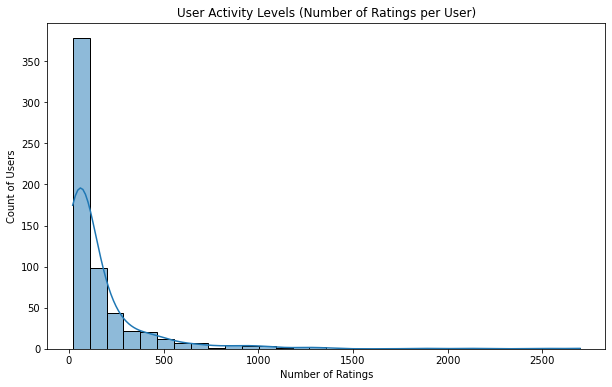

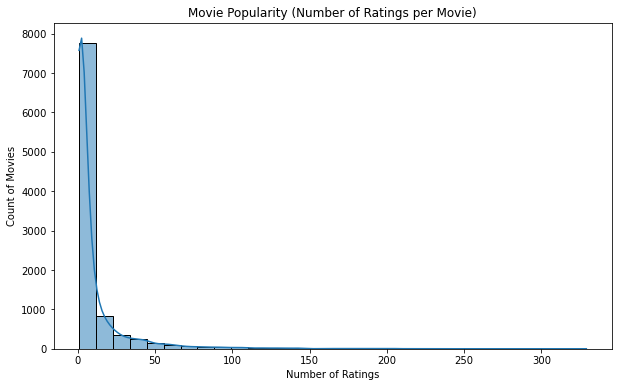

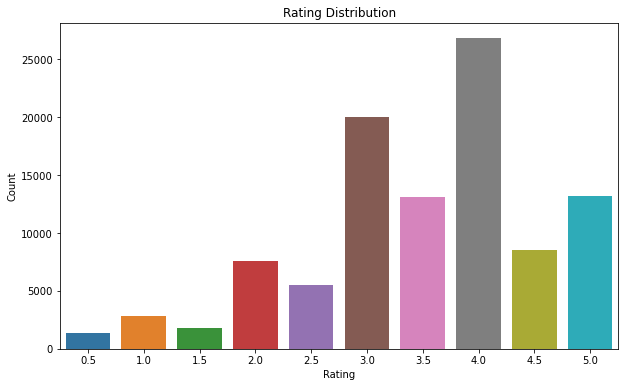

In [19]:
# Univariated Analysis
# Count the number of ratings per user
user_activity = final_df['userId'].value_counts()

# Plot the user activity distribution
plt.figure(figsize=(10,6))
sns.histplot(user_activity, bins=30, kde=True)
plt.title('User Activity Levels (Number of Ratings per User)')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.show()

# Count the number of ratings per movie
movie_popularity = final_df['movieId'].value_counts()

# Plot the movie popularity distribution
plt.figure(figsize=(10,6))
sns.histplot(movie_popularity, bins=30, kde=True)
plt.title('Movie Popularity (Number of Ratings per Movie)')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Movies')
plt.show()

# Plot the distribution of ratings
plt.figure(figsize=(10,6))
sns.countplot(x='rating', data=final_df)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


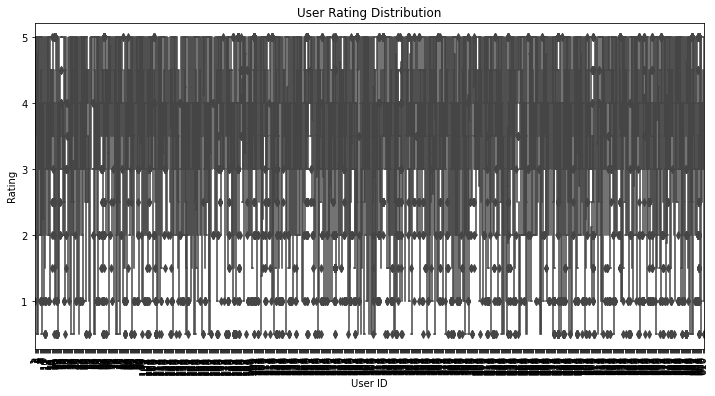

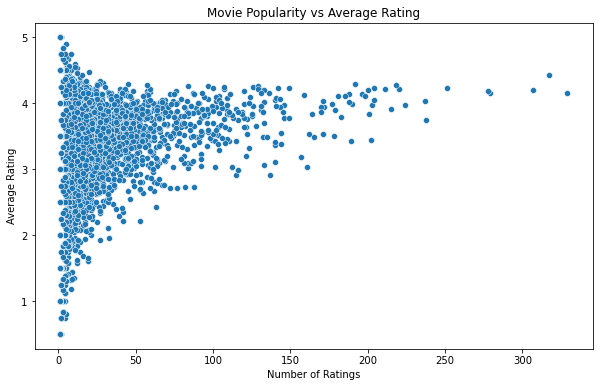

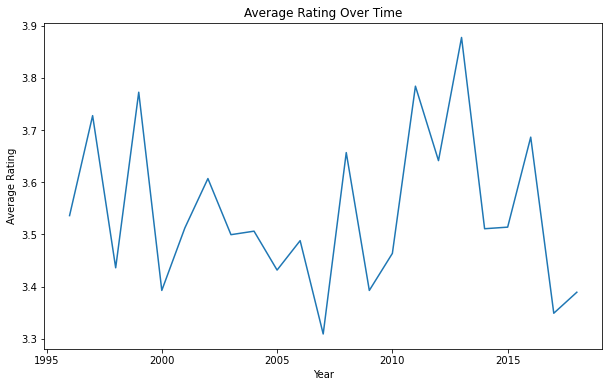

In [21]:
# Bivariate Analysis
# Plot the relationship between userId and rating
plt.figure(figsize=(12,6))
sns.boxplot(x='userId', y='rating', data=final_df)
plt.xticks(rotation=90)
plt.title('User Rating Distribution')
plt.xlabel('User ID')
plt.ylabel('Rating')
plt.show()

# Calculate average rating per movie
movie_ratings = final_df.groupby('movieId')['rating'].mean()

# Plot the movie popularity vs average rating
plt.figure(figsize=(10,6))
sns.scatterplot(x=movie_popularity, y=movie_ratings)
plt.title('Movie Popularity vs Average Rating')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.show()

# Convert timestamp to datetime format
final_df['timestamp_x'] = pd.to_datetime(final_df['timestamp_x'], unit='s')

# Extract year from timestamp
final_df['year'] = final_df['timestamp_x'].dt.year

# Group by year and calculate average rating per year
rating_trends = final_df.groupby('year')['rating'].mean()

# Plot rating trends over time
plt.figure(figsize=(10,6))
sns.lineplot(x=rating_trends.index, y=rating_trends.values)
plt.title('Average Rating Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()


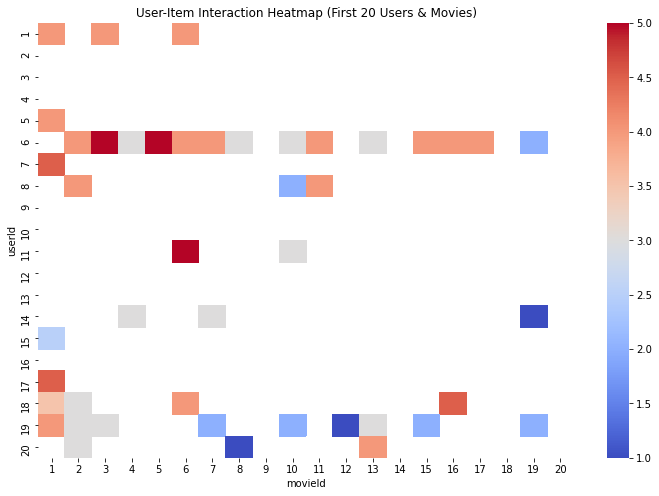

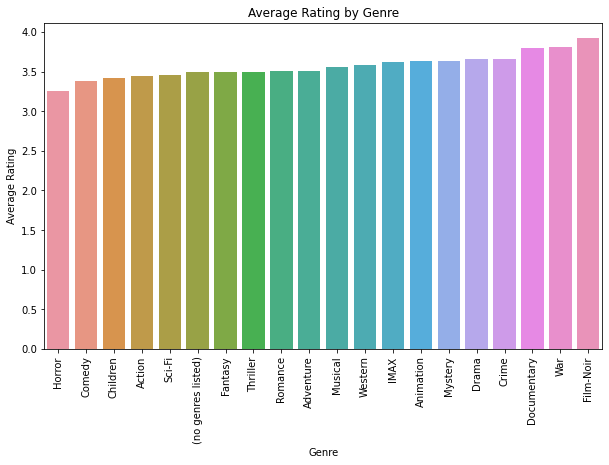

In [22]:
## Multivariate analysis
# Create a pivot table (user-item interaction matrix)
user_item_matrix = final_df.pivot_table(index='userId', columns='movieId', values='rating')

# Show a heatmap for a portion of the user-item matrix
plt.figure(figsize=(12,8))
sns.heatmap(user_item_matrix.iloc[:20, :20], cmap='coolwarm', cbar=True)
plt.title('User-Item Interaction Heatmap (First 20 Users & Movies)')
plt.show()

# Split genres into individual categories
final_df['genres_split'] = final_df['genres'].str.split('|')

# Explode the genres into individual rows
genres_df = final_df.explode('genres_split')

# Calculate average rating per genre
genre_ratings = genres_df.groupby('genres_split')['rating'].mean().sort_values()

# Plot average rating by genre
plt.figure(figsize=(10,6))
sns.barplot(x=genre_ratings.index, y=genre_ratings.values)
plt.xticks(rotation=90)
plt.title('Average Rating by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.show()


## Data preparation
Picking relevant columns for modelling

### 6. Creating User-Item Matrix

Transform the DataFrame into a matrix format where rows represent users and columns represent movies.

In [13]:
# Create a user-item matrix
user_item_matrix = final_df.pivot_table(index='userId', columns='movieId', values='rating')

# Fill NaN values with 0 (no rating)
user_item_matrix = user_item_matrix.fillna(0)

### 7. Calculating User Similarity

Compute cosine similarity between users based on their ratings.

In [14]:
# Compute the cosine similarity matrix
user_similarity = cosine_similarity(user_item_matrix)

# Convert to a DataFrame for easier access
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

NameError: name 'cosine_similarity' is not defined

### 8. Defining Recommendation Function

Create a function to generate movie recommendations for a given user.

In [ ]:
def get_user_based_recommendations(user_id, num_recommendations=5):
    # Get similar users
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:num_recommendations + 1].index

    # Get the movies rated by similar users
    similar_user_ratings = user_item_matrix.loc[similar_users]

    # Calculate the mean rating for each movie
    mean_ratings = similar_user_ratings.mean(axis=0)

    # Get the top movie recommendations
    recommended_movies = mean_ratings.sort_values(ascending=False).head(num_recommendations)

    # Return the recommended movie titles
    return final_df[final_df['movieId'].isin(recommended_movies.index)]['title'].values


### 9. Content-Based Filtering Using Genres

Implement a content-based filtering approach to recommend movies based on their genres.

In [ ]:
from scipy.sparse import csr_matrix

sampled_df = final_df.sample(frac=0.1, random_state=42)
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(sampled_df['genres'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

def get_content_based_recommendations(title):
    idx = final_df[final_df['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]
    movie_indices = [i[0] for i in sim_scores]
    return final_df['title'].iloc[movie_indices]

### 10. Testing and Evaluating the Results

Test both the user-based and content-based recommendation systems to verify their functionality. Also evaluate the quality of recommendations of the system.

In [ ]:
# Get recommendations for user ID 1
print(get_user_based_recommendations(1))

# Get recommendations for 'Toy Story (1995)'
print(get_content_based_recommendations('Toy Story (1995)'))

['Pulp Fiction (1994)' 'Pulp Fiction (1994)' 'Pulp Fiction (1994)' ...
 'Aliens (1986)' 'Aliens (1986)' 'Aliens (1986)']
36            Toy Story (1995)
237    Grumpier Old Men (1995)
256    Grumpier Old Men (1995)
304                Heat (1995)
361                Heat (1995)
Name: title, dtype: object


### 11. Limitations

- Data Sparsity: The user-item matrix may be sparse, leading to challenges in finding similar users or movies for recommendations.
- Cold Start Problem: New users or items without enough interaction history cannot be effectively recommended.
- Lack of Diversity: Recommendations may tend to favor popular movies or those similar to a user's existing ratings, limiting exploration.

### 12. Conclusion

This project successfully implemented a hybrid movie recommendation system for Netflix, combining collaborative filtering and content-based filtering approaches. The system can generate relevant recommendations based on user ratings and movie genres, enhancing user engagement and satisfaction.

### 13. Recommendations
- Incorporate More Data: Using additional features such as user demographics or movie descriptions could improve recommendation quality.
- Hybrid Approaches: Consider combining different recommendation techniques (e.g., matrix factorization) to further enhance accuracy.
- Regular Updates: The recommendation model should be periodically updated to reflect changing user preferences and new movie releases.